# Autoencoder

For each condition, $E_g$ is a gene expression vector. $C_p$ some abstract regulatory protein concentration vector (dimension $~300-500$). We model $C_p = C_p(E_g)$ with some autoencoder network.

Decoder. For each regulatory site $s$ in the genome, we have an activity $A_s = f(C_p)$. We constrain $A_s$ using PWM motif $m$ or Chip-seq factor $f$ 'indicator' matrices $N_{sm}$ and $N_{sf}^\alpha$. $\alpha$ the SVD mode.

$$A_s = f\left( \sum_{mp} N_{sm} \Lambda_{mp} C_p + \sum_{fp\alpha} N_{sf}^\alpha \Lambda_{fp}^\alpha C_p \right)$$

We learn (sparsely) the matrices $\Lambda_{mp} (which motif can be bound by protein $p$), and $\Lambda_{fp}^\alpha% (which protein $p$ influences which ChIP $f$ mode $\alpha$, thinking about complex).

Finally,

$$E_g = f\left( A_s,R_{sg} \right),$$

with $R_{sg}$ a sparse matrix (fixed or fitted), representing the regulatory influence of site $s$ on gene $g$.

There can be some intersepts (biases) in functions $f$

In [103]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import scipy
from sklearn.cross_decomposition import CCA

## Models

In [41]:
class MARA(nn.Module):
    # E_cg = A_cm N_mg + bias_g
    def __init__(self, N_mg, N_c):
        super(MARA, self).__init__()

        # Use the provided matrices and get dimenstions
        self.N_mg = N_mg
        self.N_m = N_mg.size(0)
        self.N_g = N_mg.size(1)
        self.N_c = N_c
        
        # define the A_cm matrix
        self.A_cm = nn.Parameter(torch.zeros(self.N_c, self.N_m))
        #self.mu_g = nn.Parameter(torch.zeros((1,self.N_g)))

    def forward(self):
        return torch.matmul(self.A_cm, self.N_mg)# + self.mu_g


def least_squares(N_mg, E_cg, lambda_l2):

    X = N_mg.T
    Y = E_cg.T
    # least square regression beta = (X^T X)^-1 X^T y
    C = torch.inverse(X.T @ X + lambda_l2 * torch.eye(X.shape[1]))
    beta = C @ X.T @ Y
    S = np.square(Y - X @ beta).sum()
    n = np.prod(Y.shape)
    m = np.prod(beta.shape)
    sigma2 = S/(n-m) # unbiased estimate of the variance
    var_beta = sigma2 * np.diag(C)

    # fraction of variance explained
    R2 = 1 - S / np.square(Y).sum()

    return beta, var_beta, R2

class Autoencoder(nn.Module):
    def __init__(self, N_g, N_p, N_s, Chip_sf, PWM_sm, R_sg=None):
        super(Autoencoder, self).__init__()
        
        # Use the provided matrices
        self.Chip_sf = Chip_sf
        self.PWM_sm = PWM_sm
        self.R_sg = R_sg

        # Define the dimensions
        self.N_g = N_g
        self.N_p = N_p
        self.N_s = N_s
        self.N_f = Chip_sf.size(1)
        self.N_m = PWM_sm.size(1)
        
        # Define the encoder
        self.encoder = nn.Linear(N_g, N_p, bias=True)
        
        # Define the decoder layers
        self.Lambda_mp = nn.Parameter(torch.zeros(self.N_m, self.N_p))
        self.Lambda_fp = nn.Parameter(torch.zeros(self.N_f, self.N_p))
        self.bias_E_g = nn.Parameter(torch.zeros(self.N_g)) # Bias for reconstructed E_g

    def forward(self, E_cg):
        # Encoder: C_cp = E_cg * W_gp ( + b_p )
        #self.encoder.weight.data.clamp_(0, 1)  # Clamp the weights between 0 and 1
        #self.encoder.bias.data.clamp_(0, 1)    # Clamp the biases between 0 and 1
        #C_cp = torch.sigmoid(self.encoder(E_cg))  # Linear transformation: gene space to regulatoy protein space. Use sigmoid activation function to ensure values between 0 and 1
        C_cp = self.encoder(E_cg)
        # Decoder: C_p -> A_s
        # A_s = f(sum_mp N_sm Lambda_mp C_p + sum_mp N_sf Lambda_fp C_p)
        # A_s = f( sum_p ( sum_m N_sm Lambda_mp + sum_f N_sf Lambda_fp ) C_p )
        
        # Clamp Lambda_mp and Lambda_fp parameters
        self.Lambda_mp.data.clamp_(0, 1)
        self.Lambda_fp.data.clamp_(0, 1)
        pwm_sp = torch.matmul(self.PWM_sm, self.Lambda_mp )
        chip_sp = torch.matmul(self.Chip_sf,self.Lambda_fp )
        A_cs = torch.matmul( C_cp, (pwm_sp + chip_sp).T )
        
        # Reconstruct E_cg from A_cs
        E_cg_reconstructed = torch.matmul(A_cs, self.R_sg)# + self.bias_E_g
        
        return E_cg_reconstructed

## get data

In [95]:
# run scripts/get_data.py
dataset = 'Zhang_PNAS_2014'
infile = f'../results/{dataset}.h5'
hf = h5py.File(infile, 'r')
print(hf['data'].keys())
print(hf['index'].keys())
print(hf.attrs.keys())

E_cg = torch.from_numpy(hf['data']['E_cg'][:]).to(torch.float32)

D_sg_ij = hf['data/D_sg/index'][:]
D_sg_v = hf['data/D_sg/value'][:]
D_sg_dim = hf['data/D_sg/dim'][:]

Chip_sf_ij = hf['data/Chip_sf/index'][:]
Chip_sf_v = hf['data/Chip_sf/value'][:]
Chip_sf_dim = hf['data/Chip_sf/dim'][:]
#Chip_sf = torch.sparse_coo_tensor(list(zip(*Chip_sf_ij)), list(Chip_sf_v), list(Chip_sf_dim))

PWM_sm_ij = hf['data/PWM_sm/index'][:]
PWM_sm_v = hf['data/PWM_sm/value'][:]
PWM_sm_dim = hf['data/PWM_sm/dim'][:]
#PWM_sm = torch.sparse_coo_tensor(list(zip(*PWM_sm_ij)), list(PWM_sm_v), list(PWM_sm_dim))

# dimensions
N_c, N_g = E_cg.shape
N_s, N_f = Chip_sf_dim
N_s, N_m = PWM_sm_dim
N_p = 300

<KeysViewHDF5 ['Chip_sf', 'D_sg', 'E_cg', 'PWM_sm']>
<KeysViewHDF5 ['c', 'f', 'g', 'm']>
<KeysViewHDF5 ['genome', 'pseudo_count', 'window_kb']>


## get best $\sigma$

σ = 100.0
σ = 127.42749857031335
σ = 162.3776739188721
σ = 206.913808111479
σ = 263.6650898730358
σ = 335.9818286283781
σ = 428.13323987193957
σ = 545.559478116852
σ = 695.1927961775606
σ = 885.8667904100823
σ = 1128.8378916846884
σ = 1438.449888287663
σ = 1832.9807108324355
σ = 2335.7214690901214
σ = 2976.351441631319
σ = 3792.69019073225
σ = 4832.930238571752
σ = 6158.48211066026
σ = 7847.5997035146065
σ = 10000.0
σ = 100.0
σ = 127.42749857031335
σ = 162.3776739188721
σ = 206.913808111479
σ = 263.6650898730358
σ = 335.9818286283781
σ = 428.13323987193957
σ = 545.559478116852
σ = 695.1927961775606
σ = 885.8667904100823
σ = 1128.8378916846884
σ = 1438.449888287663
σ = 1832.9807108324355
σ = 2335.7214690901214
σ = 2976.351441631319
σ = 3792.69019073225
σ = 4832.930238571752
σ = 6158.48211066026
σ = 7847.5997035146065
σ = 10000.0
σ = 100.0
σ = 127.42749857031335
σ = 162.3776739188721
σ = 206.913808111479
σ = 263.6650898730358
σ = 335.9818286283781
σ = 428.13323987193957
σ = 545.559478116

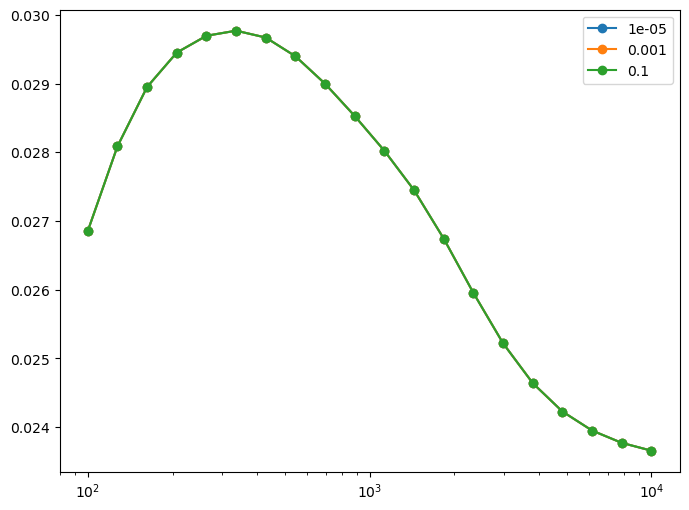

In [102]:
N_c = E_cg.shape[0]
data = E_cg.to(torch.float32)
data -= torch.mean(data, dim=0, keepdim=True)
data -= torch.mean(data, dim=1, keepdim=True)

PWM_sm = torch.sparse_coo_tensor(list(zip(*PWM_sm_ij)), list(PWM_sm_v), list(PWM_sm_dim)).to_dense().to(torch.float32)
Lambda_l2 = [1e-5,1e-3,1e-1]
Σ = np.logspace(2,4,20)


fig, ax = plt.subplots(1,1,figsize=(8,6))
for lambda_l2 in Lambda_l2:
    R2 = []
    for σ in Σ:
        print(f"σ = {σ}")

        w_sg_v = np.exp( -np.square(D_sg_v/(2*σ)) )
        W_sg =  torch.sparse_coo_tensor(list(zip(*D_sg_ij)), list(w_sg_v), list(D_sg_dim)).to(torch.float32)

        N_mg = PWM_sm.T @ W_sg
        N_mg -= torch.mean(N_mg, dim=1, keepdim=True)

        A_cm_ls, var_A_cm_ls, r2 = least_squares(N_mg, data, lambda_l2)
        R2.append(r2)

    ax.plot(Σ, R2, marker='o')
    ax.set_xscale('log')
    ax.legend(Lambda_l2)

σ = 100.0
tensor(0.1956)
σ = 166.81005372000593
tensor(0.1938)
σ = 278.2559402207126
tensor(0.1892)
σ = 464.15888336127773
tensor(0.1883)
σ = 774.263682681127
tensor(0.1909)
σ = 1291.549665014884
tensor(0.1956)
σ = 2154.4346900318824
tensor(0.1978)
σ = 3593.813663804626
tensor(0.1953)
σ = 5994.8425031894085
tensor(0.1929)
σ = 10000.0
tensor(0.1918)


(0.0, 1.0)

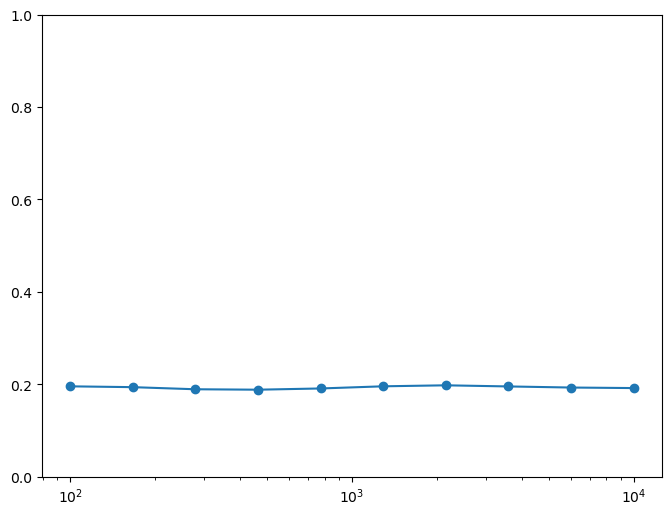

In [97]:
N_c = E_cg.shape[0]

data = E_cg
data -= torch.mean(data, dim=0, keepdim=True)
data -= torch.mean(data, dim=1, keepdim=True)

Chip_sf = torch.sparse_coo_tensor(list(zip(*Chip_sf_ij)), list(Chip_sf_v), list(Chip_sf_dim)).to_dense().to(torch.float32)

# remove columns / rows woth only zeros
#f_mask = Chip_sf.sum(0) > 0
#s_mask = Chip_sf.sum(1) > 0
#Chip_sf = Chip_sf[s_mask,:][:,f_mask]
lambda_l2 = 1e-3
Σ = np.logspace(2,4,10)
R2 = []
for σ in Σ:
    print(f"σ = {σ}")

    w_sg_v = np.exp( -np.square(D_sg_v/(2*σ)) )
    W_sg =  torch.sparse_coo_tensor(list(zip(*D_sg_ij)), list(w_sg_v), list(D_sg_dim)).to_dense().to(torch.float32)

    N_fg = Chip_sf.T @ W_sg#[s_mask,:]
    N_fg -= torch.mean(N_fg, dim=1, keepdim=True)

    A_cm_ls, var_A_cm_ls, r2 = least_squares(N_fg, data, lambda_l2)
    R2.append(r2)

    print(r2)

fig, ax = plt.subplots(1,1,figsize=(8,6))

ax.plot(Σ, R2, marker='o')
ax.set_xscale('log')

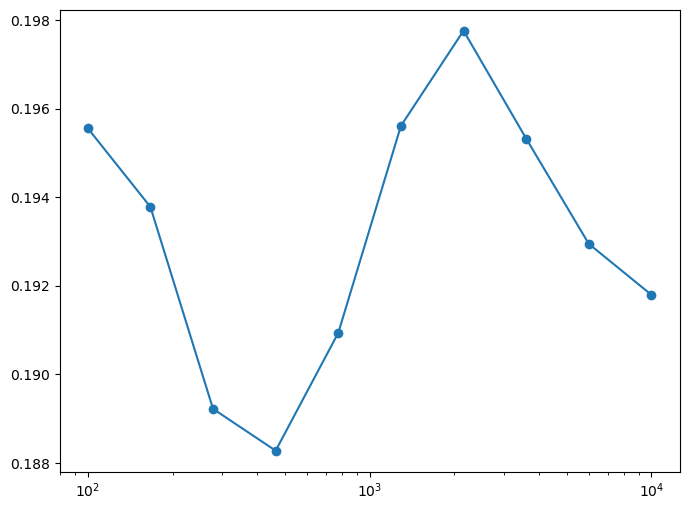

In [99]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(Σ, R2, marker='o')
ax.set_xscale('log')

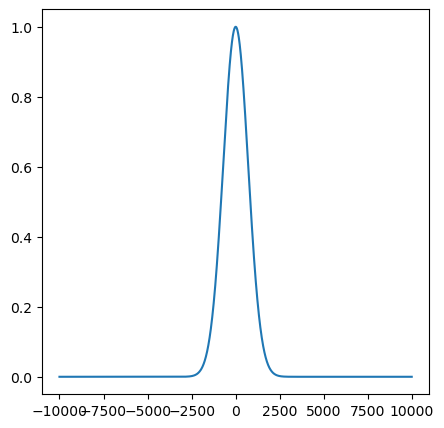

In [100]:
σ = 500
x = np.arange(-10000,10000,10)

fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(x,np.exp( -np.square(x/(2*σ) ) ))

## Initial guess for $\Lambda_{mp}$, $\Lambda_{fp}$, and $C_{cp}$

### SVD on [PWM_sf, Chip_sm]

In [22]:
# svd decomposition of PWM_sm and Chip_sf
U, S, V = torch.svd(torch.concatenate([PWM_sm,Chip_sf],1))
idx_m = np.arange(PWM_sm.shape[1])
idx_f = np.arange(Chip_sf.shape[1]) + PWM_sm.shape[1]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
frac_of_var = S**2 / (S**2).sum()
ax.plot(1-np.cumsum(frac_of_var))
ax.set_yscale('log')

n_comp = 300
Λ_mp = (V[idx_m,:n_comp]) # PWM_sm  = U S V^T => U S = PWM  V => Λ_mp = V[:p_comp]
Λ_fp = (V[idx_f,:n_comp]) # Chip_sf = U S V^T => U S = Chip V => Λ_fp = V[:p_comp]

NotImplementedError: Could not run 'aten::_linalg_svd' with arguments from the 'SparseCPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::_linalg_svd' is only available for these backends: [CPU, CUDA, HIP, MPS, IPU, XPU, HPU, VE, MTIA, PrivateUse1, PrivateUse2, PrivateUse3, Meta, FPGA, ORT, Vulkan, Metal, QuantizedCPU, QuantizedCUDA, QuantizedHIP, QuantizedMPS, QuantizedIPU, QuantizedXPU, QuantizedHPU, QuantizedVE, QuantizedMTIA, QuantizedPrivateUse1, QuantizedPrivateUse2, QuantizedPrivateUse3, QuantizedMeta, CustomRNGKeyId, MkldnnCPU, SparseCsrCPU, SparseCsrCUDA, SparseCsrHIP, SparseCsrMPS, SparseCsrIPU, SparseCsrXPU, SparseCsrHPU, SparseCsrVE, SparseCsrMTIA, SparseCsrPrivateUse1, SparseCsrPrivateUse2, SparseCsrPrivateUse3, SparseCsrMeta, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradHIP, AutogradXLA, AutogradMPS, AutogradIPU, AutogradXPU, AutogradHPU, AutogradVE, AutogradLazy, AutogradMTIA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, AutogradMeta, AutogradNestedTensor, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

Undefined: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
CPU: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCPU.cpp:31420 [kernel]
CUDA: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
HIP: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
MPS: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
IPU: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
XPU: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
HPU: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
VE: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
MTIA: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
PrivateUse1: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
PrivateUse2: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
PrivateUse3: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
Meta: registered at /dev/null:488 [kernel]
FPGA: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
ORT: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
Vulkan: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
Metal: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
QuantizedCPU: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
QuantizedCUDA: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
QuantizedHIP: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
QuantizedMPS: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
QuantizedIPU: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
QuantizedXPU: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
QuantizedHPU: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
QuantizedVE: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
QuantizedMTIA: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
QuantizedPrivateUse1: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
QuantizedPrivateUse2: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
QuantizedPrivateUse3: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
QuantizedMeta: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
CustomRNGKeyId: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
MkldnnCPU: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
SparseCsrCPU: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
SparseCsrCUDA: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
SparseCsrHIP: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
SparseCsrMPS: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
SparseCsrIPU: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
SparseCsrXPU: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
SparseCsrHPU: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
SparseCsrVE: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
SparseCsrMTIA: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
SparseCsrPrivateUse1: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
SparseCsrPrivateUse2: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
SparseCsrPrivateUse3: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
SparseCsrMeta: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/build/aten/src/ATen/RegisterCompositeExplicitAutogradNonFunctional.cpp:21612 [default backend kernel]
BackendSelect: fallthrough registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/aten/src/ATen/core/PythonFallbackKernel.cpp:154 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/aten/src/ATen/functorch/DynamicLayer.cpp:497 [backend fallback]
Functionalize: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/aten/src/ATen/FunctionalizeFallbackKernel.cpp:324 [backend fallback]
Named: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/aten/src/ATen/ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/aten/src/ATen/core/VariableFallbackKernel.cpp:86 [backend fallback]
AutogradOther: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/torch/csrc/autograd/generated/VariableType_4.cpp:17734 [autograd kernel]
AutogradCPU: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/torch/csrc/autograd/generated/VariableType_4.cpp:17734 [autograd kernel]
AutogradCUDA: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/torch/csrc/autograd/generated/VariableType_4.cpp:17734 [autograd kernel]
AutogradHIP: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/torch/csrc/autograd/generated/VariableType_4.cpp:17734 [autograd kernel]
AutogradXLA: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/torch/csrc/autograd/generated/VariableType_4.cpp:17734 [autograd kernel]
AutogradMPS: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/torch/csrc/autograd/generated/VariableType_4.cpp:17734 [autograd kernel]
AutogradIPU: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/torch/csrc/autograd/generated/VariableType_4.cpp:17734 [autograd kernel]
AutogradXPU: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/torch/csrc/autograd/generated/VariableType_4.cpp:17734 [autograd kernel]
AutogradHPU: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/torch/csrc/autograd/generated/VariableType_4.cpp:17734 [autograd kernel]
AutogradVE: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/torch/csrc/autograd/generated/VariableType_4.cpp:17734 [autograd kernel]
AutogradLazy: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/torch/csrc/autograd/generated/VariableType_4.cpp:17734 [autograd kernel]
AutogradMTIA: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/torch/csrc/autograd/generated/VariableType_4.cpp:17734 [autograd kernel]
AutogradPrivateUse1: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/torch/csrc/autograd/generated/VariableType_4.cpp:17734 [autograd kernel]
AutogradPrivateUse2: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/torch/csrc/autograd/generated/VariableType_4.cpp:17734 [autograd kernel]
AutogradPrivateUse3: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/torch/csrc/autograd/generated/VariableType_4.cpp:17734 [autograd kernel]
AutogradMeta: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/torch/csrc/autograd/generated/VariableType_4.cpp:17734 [autograd kernel]
AutogradNestedTensor: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/torch/csrc/autograd/generated/VariableType_4.cpp:17734 [autograd kernel]
Tracer: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/torch/csrc/autograd/generated/TraceType_4.cpp:13222 [kernel]
AutocastCPU: fallthrough registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/aten/src/ATen/autocast_mode.cpp:378 [backend fallback]
AutocastCUDA: fallthrough registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/aten/src/ATen/autocast_mode.cpp:244 [backend fallback]
FuncTorchBatched: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/aten/src/ATen/functorch/BatchRulesLinearAlgebra.cpp:570 [kernel]
BatchedNestedTensor: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/aten/src/ATen/functorch/VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/aten/src/ATen/LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/aten/src/ATen/functorch/TensorWrapper.cpp:202 [backend fallback]
PythonTLSSnapshot: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/aten/src/ATen/core/PythonFallbackKernel.cpp:162 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/aten/src/ATen/functorch/DynamicLayer.cpp:493 [backend fallback]
PreDispatch: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/aten/src/ATen/core/PythonFallbackKernel.cpp:166 [backend fallback]
PythonDispatcher: registered at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/aten/src/ATen/core/PythonFallbackKernel.cpp:158 [backend fallback]


### CAA

In [104]:
caa = CCA(n_components=3)
caa.fit(PWM_sm,Chip_sf)
X_c, Y_c = caa.transform(PWM_sm,Chip_sf)

In [111]:
x = caa.x_loadings_
y = caa.y_loadings_

In [117]:
torch.corrcoef( torch.concatenate([ PWM_sm @ x[:,0],Chip_sf @ y[:,0] ],axis=0) )

tensor(1., dtype=torch.float64)

In [122]:
torch.corrcoef(  torch.concatenate([ (PWM_sm @ x).T,(Chip_sf @ y).T ],axis=0) )

tensor([[ 1.0000, -0.6363, -0.7523,  0.1351,  0.0089,  0.0638],
        [-0.6363,  1.0000,  0.8767,  0.0582,  0.1621,  0.1181],
        [-0.7523,  0.8767,  1.0000,  0.0670,  0.1743,  0.1305],
        [ 0.1351,  0.0582,  0.0670,  1.0000,  0.9314,  0.9777],
        [ 0.0089,  0.1621,  0.1743,  0.9314,  1.0000,  0.9868],
        [ 0.0638,  0.1181,  0.1305,  0.9777,  0.9868,  1.0000]],
       dtype=torch.float64)

cpu
Epoch [1/100], taining MSE: 9240.0717, l1_loss: 34.6173, Validation MSE: 0.9606
Epoch [2/100], taining MSE: 1.1829, l1_loss: 0.0000, Validation MSE: 0.9606
Epoch [3/100], taining MSE: 1.1315, l1_loss: 0.0191, Validation MSE: 0.9051
Epoch [4/100], taining MSE: 1.0803, l1_loss: 0.0350, Validation MSE: 0.9079
Epoch [5/100], taining MSE: 1.0723, l1_loss: 0.0350, Validation MSE: 0.9064
Epoch [6/100], taining MSE: 1.0751, l1_loss: 0.0349, Validation MSE: 0.9043
Epoch [7/100], taining MSE: 1.0727, l1_loss: 0.0353, Validation MSE: 0.9099
Epoch [8/100], taining MSE: 1.0720, l1_loss: 0.0388, Validation MSE: 0.9054
Epoch [9/100], taining MSE: 1.0805, l1_loss: 0.0379, Validation MSE: 0.9171
Epoch [10/100], taining MSE: 1.1253, l1_loss: 0.0392, Validation MSE: 0.9314
Epoch [11/100], taining MSE: 1.4859, l1_loss: 0.0335, Validation MSE: 0.9477
Epoch [12/100], taining MSE: 1.1060, l1_loss: 0.0452, Validation MSE: 0.9006
Epoch [13/100], taining MSE: 1.0941, l1_loss: 0.0448, Validation MSE: 0.9236


Text(0, 0.5, 'Loss')

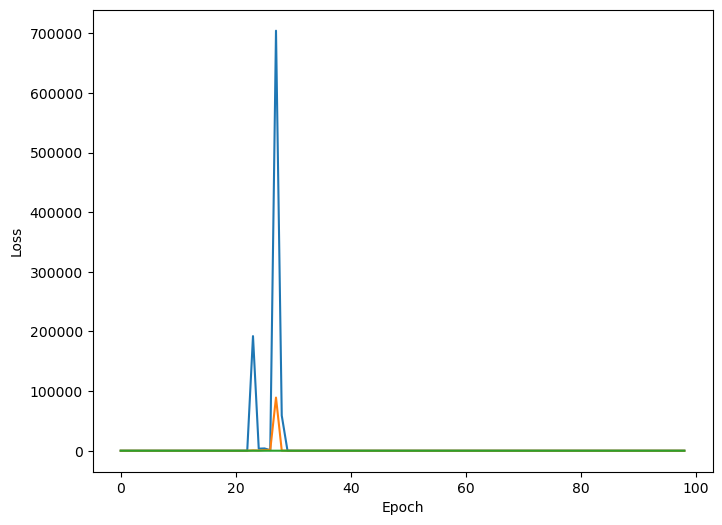

In [25]:


# Determine the device to use (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Define the model, loss function and optimizer
model = Autoencoder(N_g, N_p, N_s, Chip_sf, PWM_sm, R_sg)
model.to(device)
lr = 0.001
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Define the loss function with L1 regularization
def l1_penalty(matrix):
    return torch.sum(torch.abs(matrix))

# Dummy data for illustration; in practice, use your dataset
num_epochs = 100 # Number of training epochs
l1_lambda = 1e-6  # L1 regularization strength
batch_size = E_cg.shape[0]  # Use the entire dataset as a batch

# Convert the gene expression data to a PyTorch tensor
num_samples = E_cg.shape[0]
E_cg_data = torch.from_numpy(E_cg.values - E_cg.values.mean(0)).to(torch.float32)
train_size = int(0.9 * num_samples)
val_size = num_samples - train_size
E_cg_train = E_cg_data[:train_size]
E_cg_val = E_cg_data[train_size:]

train_dataset = TensorDataset(E_cg_train)
val_dataset = TensorDataset(E_cg_val)
#dataset = TensorDataset(E_cg_data)
#data_loader = DataLoader(dataset, batch_size=32, shuffle=True)#, num_workers=32)
batch_size = int(train_size/10)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=val_size, shuffle=False)

# Training loop
train_mse = np.zeros(num_epochs)
l1_pen = np.zeros(num_epochs)
val_mse = np.zeros(num_epochs)
for epoch in range(num_epochs):

    model.train()  # Set the model to training mode
    for batch in train_loader:
        E_g = batch[0]  # Get the input gene expression vector
        E_g = E_g.to(torch.float32)
        
        optimizer.zero_grad()  # Zero the gradients
        E_g_reconstructed = model(E_g)  # Forward pass
        
        # Compute the reconstruction loss
        reconstruction_loss = loss_function(E_g_reconstructed, E_g)
        train_mse[epoch] += reconstruction_loss.item()

        # L1 regularization
        l1_loss = l1_penalty(model.Lambda_mp) + l1_penalty(model.Lambda_fp)
        l1_pen[epoch] += l1_loss.item()

        # Total loss
        loss = reconstruction_loss + l1_lambda * l1_loss
        loss.backward()  # Backpropagate the gradients
        optimizer.step()  # Update the parameters
    
    train_mse[epoch] /= len(train_loader)
    l1_pen[epoch] /= len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], taining MSE: {train_mse[epoch]:.4f}, l1_loss: {l1_pen[epoch]:.4f}", end='')

    # Validation step
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for batch in val_loader:
            E_g = batch[0]  # Get the input gene expression vector
            E_g = E_g.to(torch.float32)
            E_g_reconstructed = model(E_g)  # Forward pass
            reconstruction_loss = loss_function(E_g_reconstructed, E_g)  # Compute the reconstruction loss
            val_mse[epoch] += reconstruction_loss.item()
    
    val_mse[epoch] /= len(val_loader)
    print(f", Validation MSE: {val_mse[epoch]:.4f}")

# Plot the loss curve
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(train_mse[1:], label='Training MSE')
ax.plot(val_mse[1:], label='Validation MSE')
ax.plot(l1_pen[1:], label='L1 penalty')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')


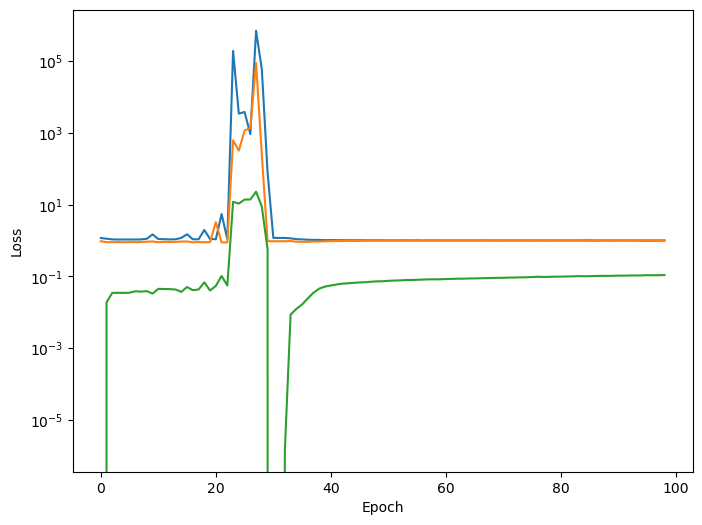

In [94]:
# Plot the loss curve
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(train_mse[1:], label='Training MSE')
ax.plot(val_mse[1:], label='Validation MSE')
ax.plot(l1_pen[1:], label='L1 penalty')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_yscale('log')

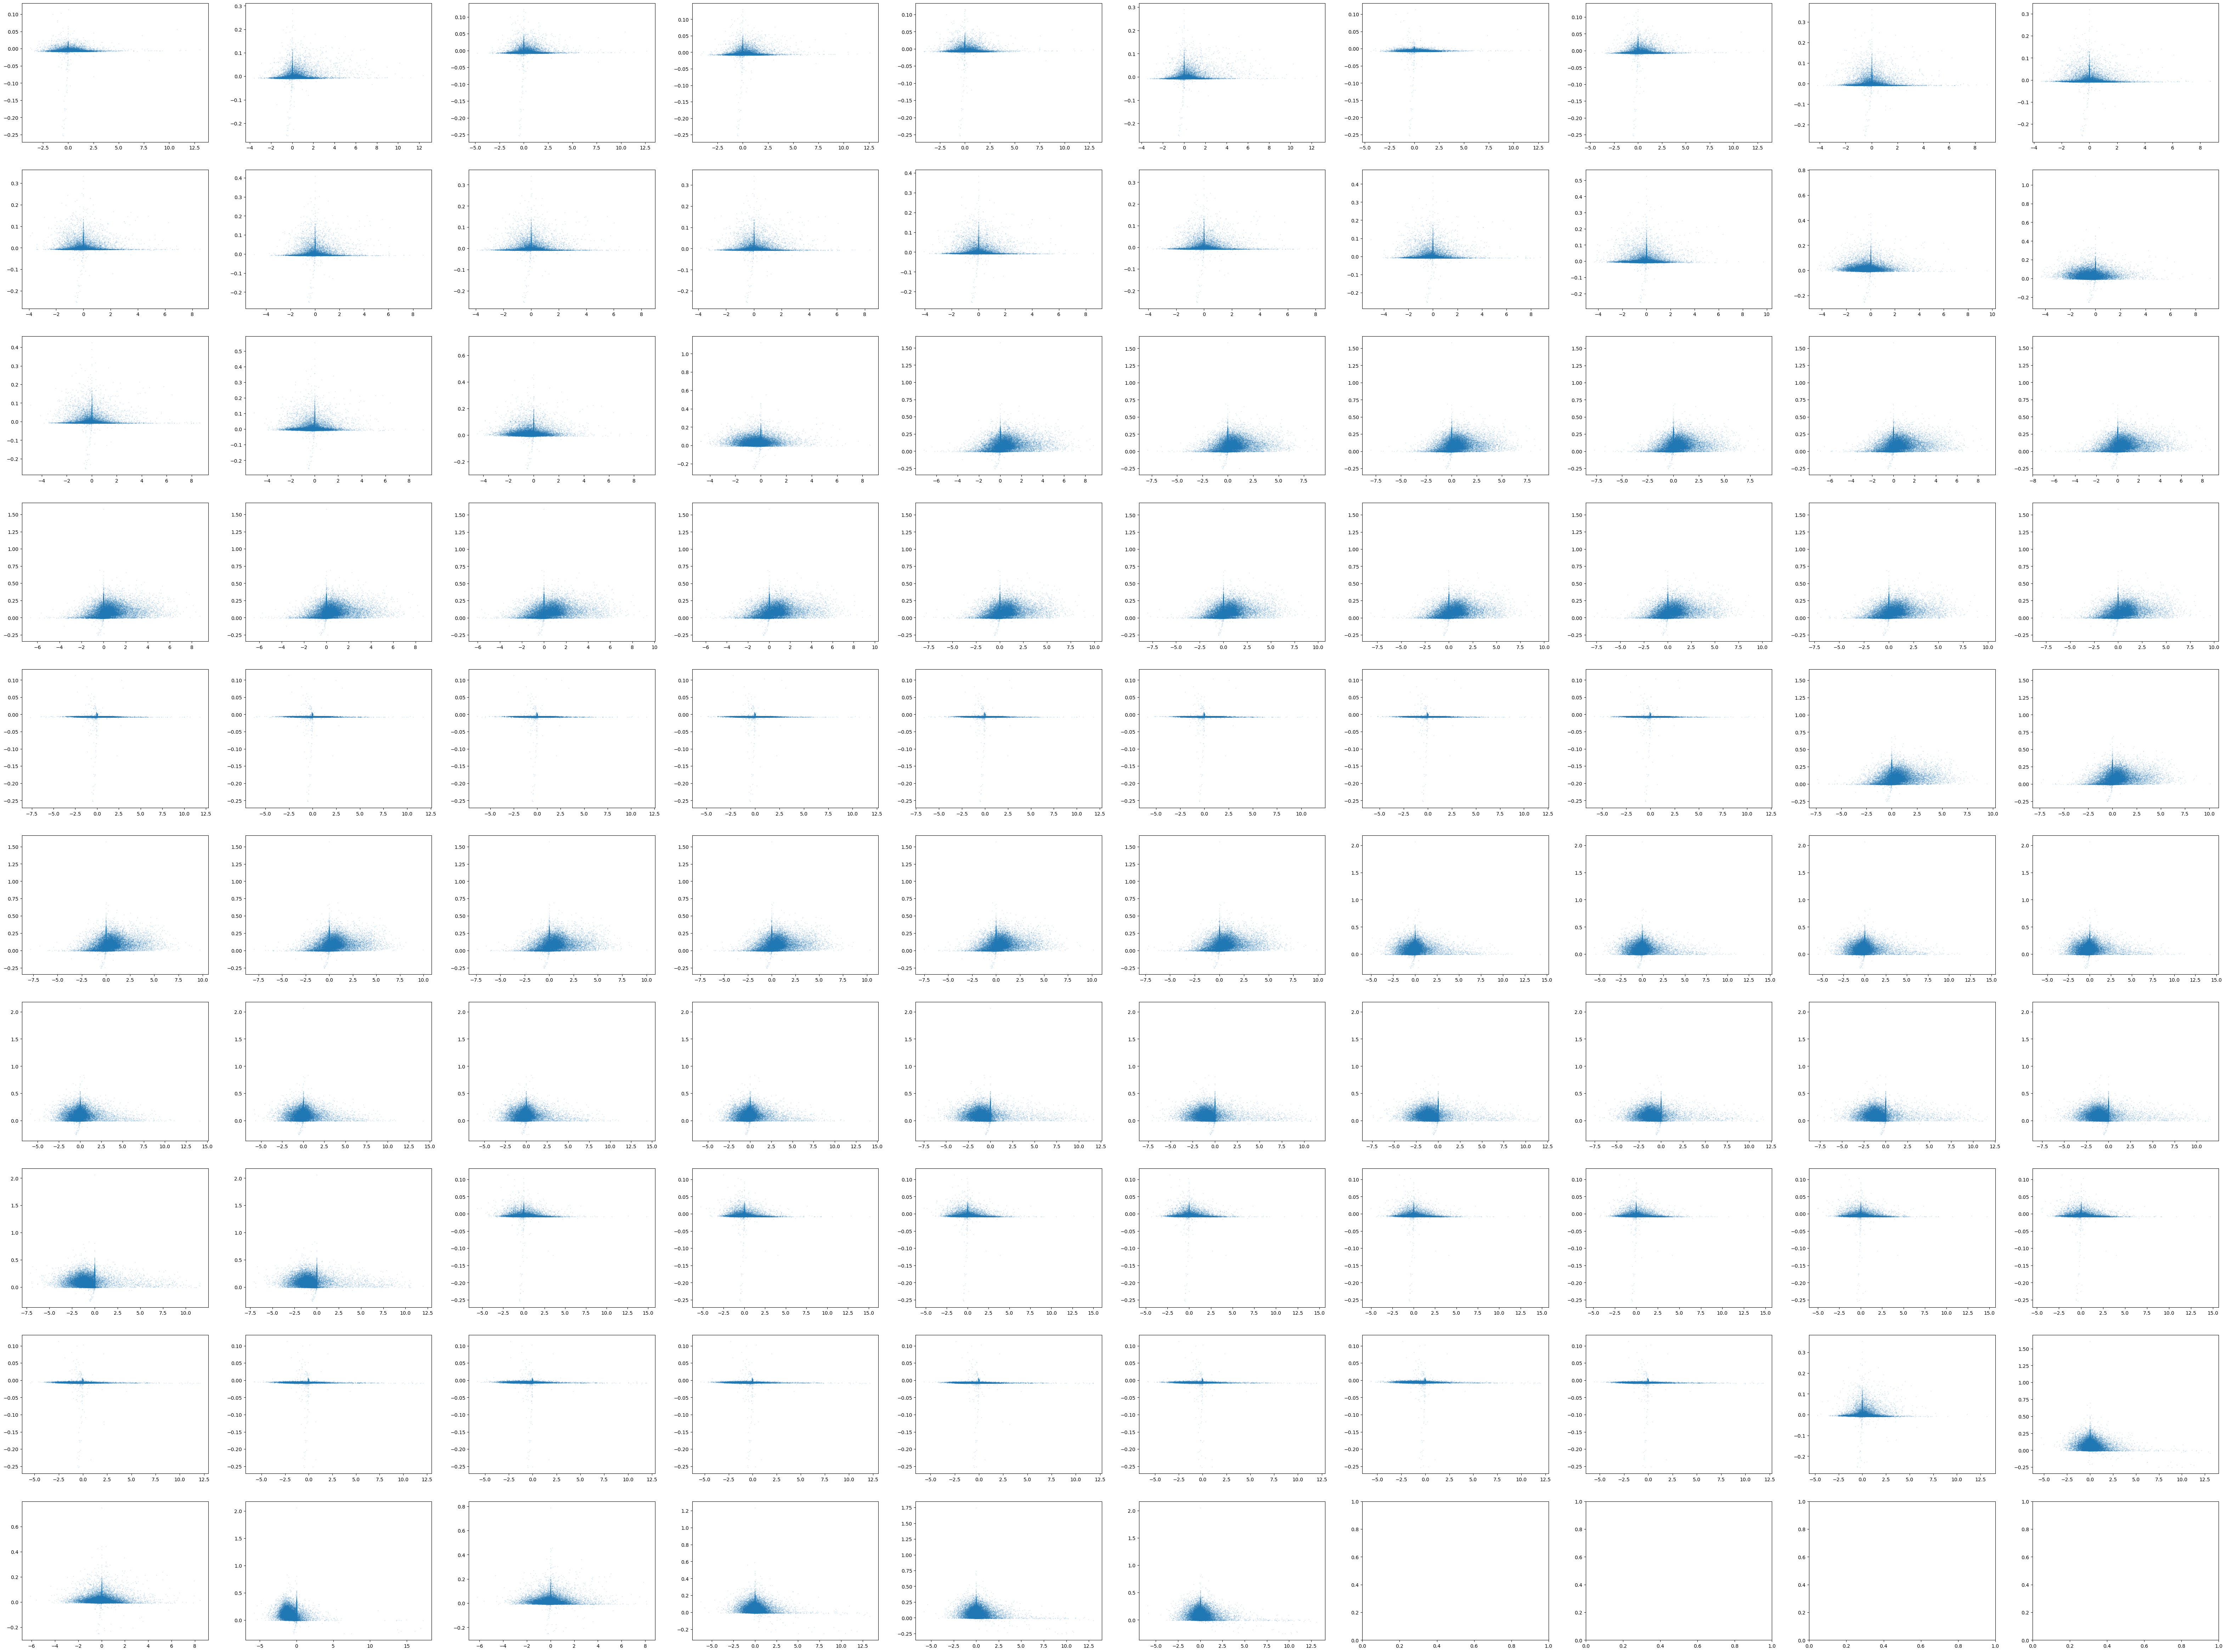

In [52]:
E_cg_reconstructed = model(E_cg_data)

n_sample = E_cg.shape[0]
R2 = np.zeros(n_sample)

fig, axes = plt.subplots(10,10, figsize=(80, 60))
for c in range(n_sample):
    R2[c] = torch.corrcoef( torch.concat([E_cg_data[[c],:], E_cg_reconstructed.detach()[[c],:]], axis=0) )[0,1]**2

    ax = axes.flatten()[c]
    ax.scatter(E_cg_data[c,:], E_cg_reconstructed.detach()[c,:], s=1, alpha= 0.1)
    ax.set_title(fr"$R^2 = {R2[c]:.2f}$")

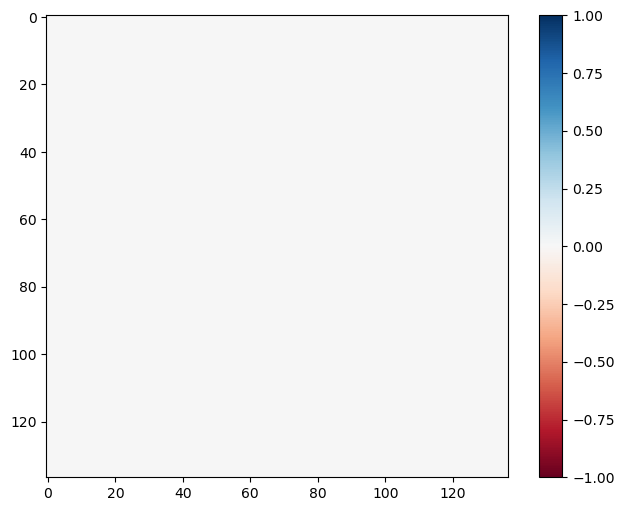

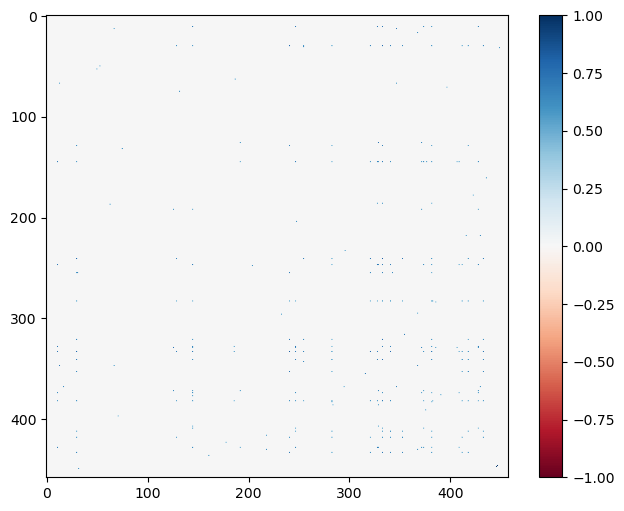

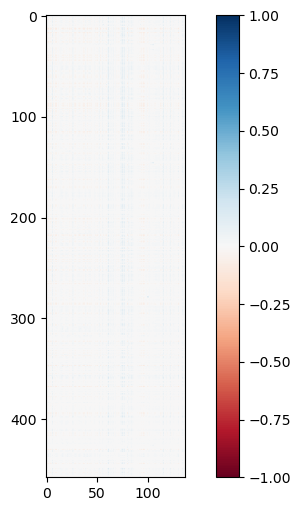

In [86]:
N_f = Chip_sf.size(1)
N_m = PWM_sm.size(1)

R_m = torch.corrcoef(PWM_sm.T)
R_m -= torch.eye(R_m.shape[0])
R_m[R_m**2<.5] = 0

R_f = torch.corrcoef(Chip_sf.T)
R_f -= torch.eye(R_f.shape[0])
R_f[R_f**2<.5] = 0

R_fm = torch.zeros([N_f,N_m])
for f in range(N_f):
    for m in range(N_m):
        R_fm[f,m] = torch.corrcoef( torch.concatenate([PWM_sm[:,[m]],Chip_sf[:,[f]]],1).T )[0,1]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
h = ax.imshow(R_m, cmap='RdBu', vmin=-1, vmax=1)
fig.colorbar(h)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
h = ax.imshow(R_f, cmap='RdBu', vmin=-1, vmax=1)
fig.colorbar(h)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
h = ax.imshow(R_fm, cmap='RdBu', vmin=-1, vmax=1)
fig.colorbar(h)

# Mara model

## Train model

In [83]:
σ = 500
w_sg_v = np.exp( -np.square(D_sg_v/(2*σ)) )
W_sg =  torch.sparse_coo_tensor(list(zip(*D_sg_ij)), list(w_sg_v), list(D_sg_dim)).to(torch.float32)

N_mg = PWM_sm.T @ W_sg
N_c = E_cg.shape[0]
data = E_cg
data -= torch.mean(data, dim=0, keepdim=True)
data -= torch.mean(data, dim=1, keepdim=True)
N_mg -= torch.mean(N_mg, dim=1, keepdim=True)
model = MARA(N_mg, N_c)
loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.2)

n_epochs = 5000
lambda_l2 = 1e-3

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    estimate = model()

    # Compute the loss
    l2_penalty = torch.sum(torch.square(model.A_cm))
    loss = loss_function(estimate, data) + lambda_l2 * l2_penalty # + model.entropy_loss()

    # Backward pass
    loss.backward()

    # Update the parameters
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}")

# Show final weights
A_cm = model.A_cm

predicted = model()
R2 = 1 - torch.square(data - predicted).sum() / torch.square(data).sum()
print(f'R2: {R2:.3f}')

A_cm_ls, var_A_cm_ls, r2 = least_squares(N_mg, data, lambda_l2)
print(f'R2: {r2:.3f}')

Epoch [100/5000], Loss: 1.0600
Epoch [200/5000], Loss: 1.0565
Epoch [300/5000], Loss: 1.0546
Epoch [400/5000], Loss: 1.0534
Epoch [500/5000], Loss: 1.0526
Epoch [600/5000], Loss: 1.0520
Epoch [700/5000], Loss: 1.0516
Epoch [800/5000], Loss: 1.0513
Epoch [900/5000], Loss: 1.0510
Epoch [1000/5000], Loss: 1.0508
Epoch [1100/5000], Loss: 1.0506
Epoch [1200/5000], Loss: 1.0505
Epoch [1300/5000], Loss: 1.0504
Epoch [1400/5000], Loss: 1.0503
Epoch [1500/5000], Loss: 1.0502
Epoch [1600/5000], Loss: 1.0502
Epoch [1700/5000], Loss: 1.0501
Epoch [1800/5000], Loss: 1.0501
Epoch [1900/5000], Loss: 1.0500
Epoch [2000/5000], Loss: 1.0500
Epoch [2100/5000], Loss: 1.0500
Epoch [2200/5000], Loss: 1.0500
Epoch [2300/5000], Loss: 1.0499
Epoch [2400/5000], Loss: 1.0499
Epoch [2500/5000], Loss: 1.0499
Epoch [2600/5000], Loss: 1.0499
Epoch [2700/5000], Loss: 1.0499
Epoch [2800/5000], Loss: 1.0499
Epoch [2900/5000], Loss: 1.0499
Epoch [3000/5000], Loss: 1.0499
Epoch [3100/5000], Loss: 1.0499
Epoch [3200/5000]

In [85]:
#N_mg = torch.matmul( torch.concatenate([Chip_sf, PWM_sm], axis=1).T, R_sg )

σ = 500
w_sg_v = np.exp( -np.square(D_sg_v/(2*σ)) )
W_sg =  torch.sparse_coo_tensor(list(zip(*D_sg_ij)), list(w_sg_v), list(D_sg_dim)).to(torch.float32)

N_mg = Chip_sf.T @ W_sg

N_c = E_cg.shape[0]
data = E_cg
data -= torch.mean(data, dim=0, keepdim=True)
data -= torch.mean(data, dim=1, keepdim=True)

model = MARA(N_mg, N_c)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

n_epochs = 1000
lambda_l2 = 1e-3

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    estimate = model()
    l2_penalty = torch.sum(torch.square(model.A_cm))
    loss = loss_function(estimate, data) + lambda_l2 * l2_penalty
    # + model.entropy_loss()

    # Backward pass
    loss.backward()

    # Update the parameters
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}")

    

# Show final weights
A_cm = model.A_cm

predicted = model()
R2 = 1 - torch.square(data - predicted).sum() / torch.square(data).sum()
print(f'R2: {R2:.3f}')

A_cm_ls = least_squares(N_mg, data, lambda_l2)

prediction_ls = torch.matmul(A_cm_ls.T, N_mg)

RuntimeError: addmm: Argument #3 (dense): Expected dim 0 size 184463, got 164911

/tmp/ipykernel_7405/1056570836.py:5: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(H),origin='lower')
/tmp/ipykernel_7405/1056570836.py:12: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(H),origin='lower')
/tmp/ipykernel_7405/1056570836.py:20: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(H),origin='lower')


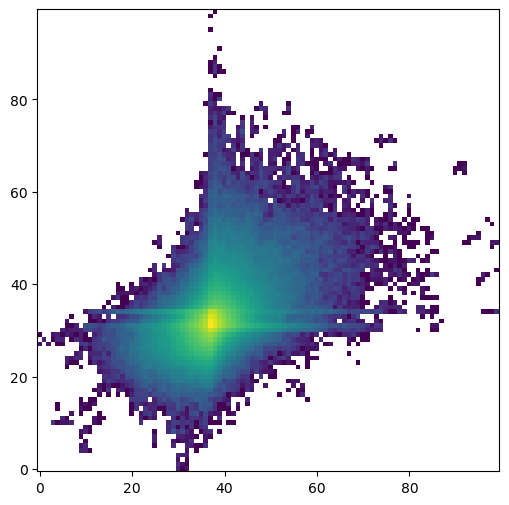

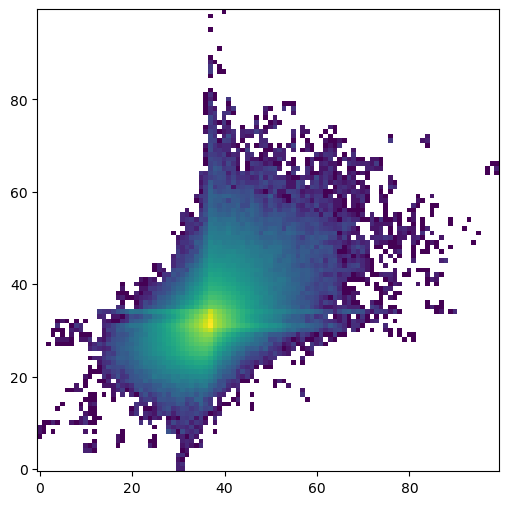

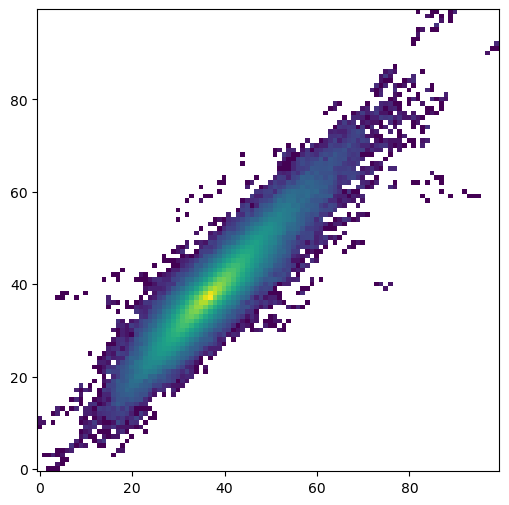

In [42]:

# plot in 2d histogram
H, x_edge, y_edge = np.histogram2d(data.flatten(), predicted.detach().flatten(), bins=100)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.imshow(np.log10(H),origin='lower')


# plot in 2d histogram
H, x_edge, y_edge = np.histogram2d(data.flatten(), prediction_ls.flatten(), bins=100)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.imshow(np.log10(H),origin='lower')


#ax.scatter(data.flatten(), predicted.detach().flatten(), s=1, alpha=0.1)
# plot in 2d histogram
H, x_edge, y_edge = np.histogram2d( predicted.detach().flatten(), prediction_ls.flatten(), bins=100)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.imshow(np.log10(H),origin='lower')

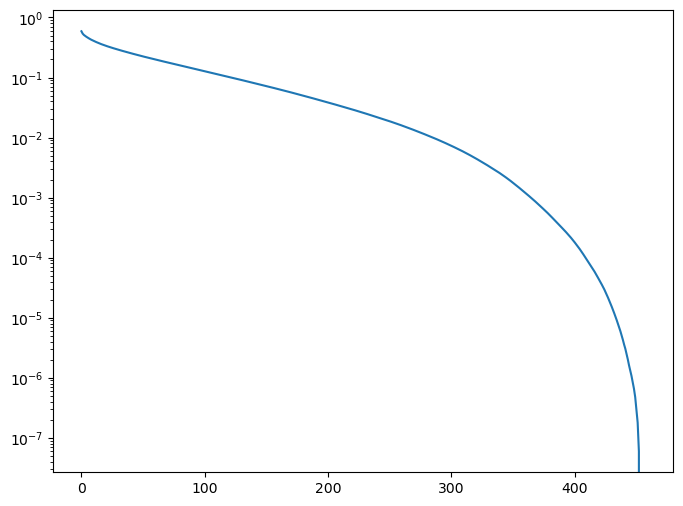

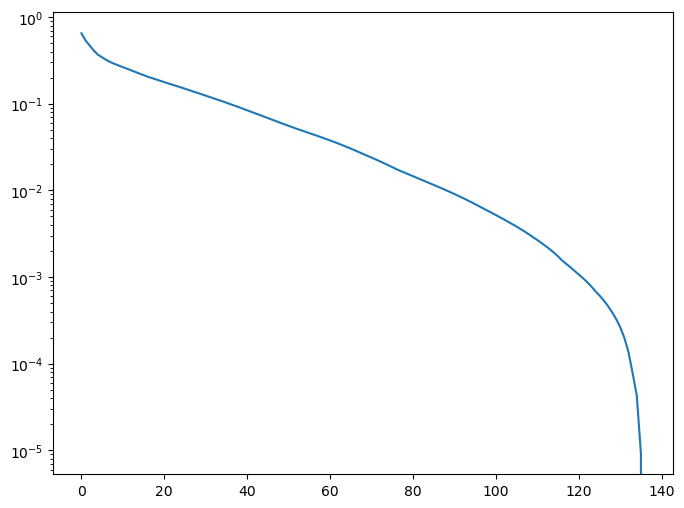

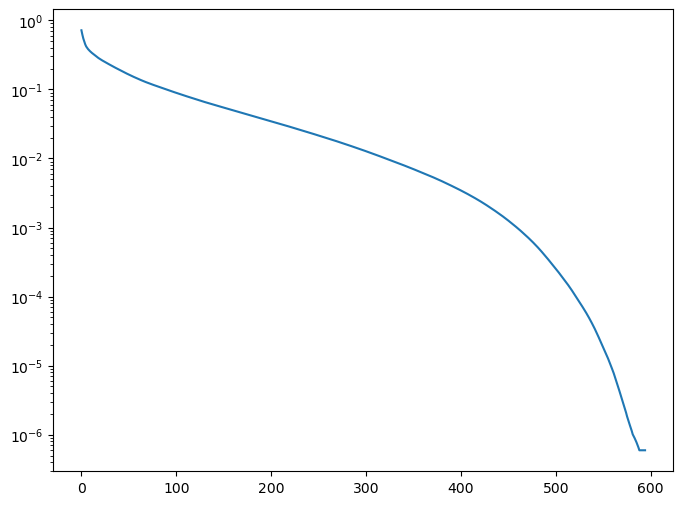